# Machine Learning with Probabilistic Programming 2020 - Jonah Deykin and Siddharth Mane




## **1. Introduction**

A financial bubble is one of the most daunting risks in the modern world. The crash or "bubble burst" following a financial bubble has the potential to devastate national economies and thus the detection of these bubbles and the prediction of their crashes becomes a compelling question. As such, the problem of detecting financial bubbles has attracted interest from disparate disciplines. The sheer magnititude and availability of quantitative financial data makes such a task especially apt for the methods of Probabilistic Programming. Our problem is thus a two-pronged one: 1) how to identify a financial bubble and 2) how to determine the timing and magnitude of the crash following the bubble.

Previous attempts at the detection of financial bubbles have met difficulty in determining a model robust enough to sufficiently track and predict market price movements. By understanding these price movements, we can detect the formation of a bubble (rapid price increases) and the "burst" of that bubble (rapid price decreases). In this paper, we intend to develop a Markovian model that predicts price fluctuations in time-series financial data.

## **2. Data**

We gathered data (from Kaggle) on the 468 corporations that were on the S&P 500 for the entirety of the five year period between 13 February 2013 and 12 February 2018. In this data were the daily closing price, daily price spread (difference between highest and lowest price during a trading day), and daily trading volume for each corporation's stock. In total, we gathered these three data points for these 468 corporations for 1257 days, for a total of 1,764,828 data points. Specific use of the data will be catalogued in the model descriptions following this section.

## **3. Models**


### 3.1 Initial Approach

We began with two ideas: 1) modeling crash probability as a multivariate normal distribution and 2) modeling crash probability as the Log Periodic Power Law (LPPL) (and placing normal priors on the variables therein). Neither of these models succeeded despite considerable effort. The multivariate normal was extremely difficult to specify fully, as we needed to weight the respective parameters of the normal distributions ourselves. We came to realize that we either ought to be modelling simply on the data we want to infer, or that we ought to use some type of deep network to make these observations for us. For the Bayesian LPPL a similar issue occured, namely, that we would need extensive empirical data (that we would have to gather) to have any chance of a reasonable model. Thus we rethought modeling price changes, and we drifted the world of time series analysis.

### 3.2 Hidden Markov Model

#### 3.2.1 Description


We began with the assumption that price movement was Markovian. We believed that a properly trained transition matrix could effectively transition between percent price changes. There are several (fairly recent) pieces of literature regarding the use of Hidden Markov models in financial modeling. We hoped to implement such a model in Pyro. Financial data (especially price change) tends to be very noisy. With this in mind, we required a model and inference technique that were designed for very noisy data. We determined that Pyro's GaussianHMM class would suffice to this end. The GaussianHMM class builds a Hidden Markov Model with Gaussian priors on the initial, transition, and observation distributions. The joint probability distribution for such a model is: $$P(z_{1:T} | x_{1:T}) = P(z_{1:T}) P(x_{1:T} | z_{1:T})  $$ $$ = (P(z_1)\prod_{i = 2}^T P(z_i|z_{i-1}))(\prod_{i = 2}^T P(x_i|z_i))$$ Where $P(z_i)$ (hidden distribution) is a Gaussian, $P(z_i|z_{i-1})$ is the Gaussian transition distribution, and $P(x_i | z_i)$ is the Gaussian observation distribution. The state of maximum likelihood yields the price change. This model was trained on individual security daily closing percentage price changes (a series of 700 data points) and then used to predict the next 704 points of that security's daily closing percentage price changes. Training and inference were performed using the predict function in Pyro's built-in Forecaster class. Since the data were noisy and were of zero mean almost everywhere, the periodic portion of the forecaster class was set to zero.

#### 3.2.2 Implementation

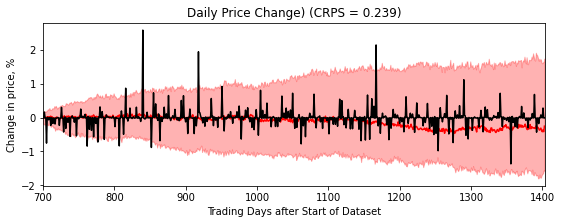

In [3]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

class MM(ForecastingModel):
	def model(self, zero_data, covariates):
		duration = zero_data.size(-2)
		init_dist = dist.Normal(0, 0.05).expand([1]).to_event(1)
		obs_dist = dist.Normal(0, 0.1).expand([1]).to_event(1)
		obs_matrix = torch.tensor([[1.]])
		trans_dist = dist.Normal(0, 0.05).expand([1]).to_event(1)
		trans_matrix = torch.tensor([[1.]])
		pre_dist = dist.GaussianHMM(init_dist,trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
		prediction = periodic_repeat(torch.zeros(1, 1), duration, dim=-1).unsqueeze(-1)
		self.predict(pre_dist, prediction)

def main():
    asset = 0
    data = torch.load('data.pt').transpose(-1, -2)
    assert (asset >= 0 and asset < data.size(-2))
    data = data[asset]
    data = data[:, None]
    TrainTime = 700
    TotalTime = data.size(-2)
    assert (TrainTime <= TotalTime and TrainTime > 0)
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    covariates = torch.zeros(len(data), 0)
    forecaster = (Forecaster(MM(), data[:TrainTime],
                  covariates[:TrainTime], learning_rate=0.1, num_steps=0))
    samples = forecaster(data[:TrainTime], covariates, num_samples=100)
    p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
    crps = eval_crps(samples, data[TrainTime:])
    plt.figure(figsize=(9, 3))
    plt.fill_between(torch.arange(TrainTime, TotalTime), p10, p90,
                     color="red", alpha=0.3)
    plt.plot(torch.arange(TrainTime, TotalTime), p50, 'r-',
             label='price change forecast')
    plt.plot(torch.arange(TrainTime, TotalTime),
             data[TrainTime: TotalTime], 'k-', label='price change truth')
    plt.title("Daily Price Change) (CRPS = {:0.3g})".format(crps))
    plt.ylabel("Change in price, %")
    plt.xlabel("Trading Days after Start of Dataset")
    plt.xlim(TrainTime, TotalTime)
    
if __name__ == '__main__':
	main()	

#### 3.2.3 Empirical Results

Ultimately, in a model that purports to detect market price changes, an important question is how well it detects drops and increases within the market. To this end our Hidden Markov model demonstrates 57.0 percent accuracy at determining correctly whether an asset price will increase or decrease on a given day across all assets. Additionally, the Hidden Markov model yielded a recall of 57.3 percent on asset price decreases in a given day across all assets. However, graphical posterior predictive checks yielded issues: in particular, the model (regardless of parameter setting) tends to predict a "super-crash" towarards the tail end of the data, where all daily price changes are negative for a long period. This generates demand for a model that is more consistent in its predictions.

### 3.3 Deep Temporal Sigmoid Belief Model


#### 3.3.1 Description

Due to the time series nature of our data we still believed a markovian model would best describe our data.  However, we needed a model capable of modeling more complex functions than what a simple HMM could produce.  In our search for an appropriate model we found the Deep Temporal Sigmoid Belief Network <sup>1</sup>.  The Deep Temporal Sigmoid Belief Network is actually composed of two different networks. The generative network is composed of sigmoid belief layers that stack on top of each other and lead to a final output layer, which in our case maps the final hidden state to real valued data.  This layer attempts to generate the next data point based on the previous hidden state and data point. The recognition network is composed soley of sigmoid belief layers.  This network attempts to generate the hidden states that produced a given data point, using the previous infered hidden states and current data point. A visual representation of the model is shown below. 

<img src="DTSBN.png" alt="drawing" width="500"/>

Given dataset *V* = {*v<sub>1</sub>*, *v<sub>2</sub>*, ... , *v<sub>t</sub>*}, an accompanying set of hidden states *H* = {*h<sub>1</sub>*, *h<sub>2</sub>*, ... , *h<sub>T</sub>*}, and a set of parameters $\theta$, $$P_{\theta}(V, H) = \Pi^{T}_{t=1} P_{\theta}(h_t|h_{t-1},v_{t-1})P_{\theta}(v_t|h_{t},v_{t-1})$$  with *h<sub>0</sub>*, *v<sub>0</sub>* defined as zero vectors to make the calculations possible.  As we are attempting to predict the crash probabilite at time *T*, we can write $$P_{\theta}(crash_T|\{v_1, v_2, ... ,v_{t-1}\}) =  \sum_{V_c}\sum_H P_{\theta}(\{v_1, v_2, ... ,v_{t-1}, v_c \}, h)$$ where *V<sub>c</sub>* is the set of all *v<sub>T</sub>* that would constitute a crash.  Unfortunately however, there is not a closed form solution to this probablility for Deep Temporal Sigmoid Belief Networks.  Hence we estimate the crash probability via monte carlo sampling from the model.  Suppose we have *n* samples drawn from the model for *v<sub>T</sub>* with mean *v<sub>$\mu$</sub>* and standard deviation *v<sub>$\sigma$</sub>*, then the probability of a crash to or below level *C* is given as $$\frac{1}{v_{\sigma}\sqrt{2\pi}}\int_{-\infty}^{C}e^{-\frac{(x-v_{\mu})}{2v_{\sigma}^2}}dx$$

#### 3.3.2 Implementation

As the DTSBN does not exist prebuilt in pyro, we built it in torch using the original DTSBN paper as a reference

In [16]:
#Load the data
data = torch.load('data.pt')

train_data = data[:, :int(data.size()[1]/3)*2]
test_data = data[:, int(data.size()[1]/3)*2:]

In [17]:
import DTSBN
import read_data
import test_pred
import torch 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to
import pyro.contrib.gp as gp
import math
import numpy as np
import random 
pyro.set_rng_seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
random.seed(1)



In [18]:
#Define the base model
data_size = 1404
hidden_size = 1404
dims = [hidden_size, data_size]
DTSBN_base = DTSBN.DTSBN(dims, 1, 1)

#Define the Data Dependent Baseline
dims.reverse()
DDBL_base = DTSBN.DDBL(dims)

#### 3.4 Inference

This model is train using an inference technique called Neural Variational Infrence and Learning (NVIL)<sup>4</sup>.  Similar to BBVI, this technique uses gradiuent ascent to maximize the ELBO, and was designed specificaly to work with belief networks.  A particularly interesting feature of the technique is that is trains a neural network which acts as a variance reduction technique on the gradients.  Once the gradients are calculated, the weights are updated using the ADAM optimization algorithm.  Similar to the model itself, this technique is not supported by Pyro, so we implemented it in torch.

In [19]:
#Show training of model
D = DTSBN.Adam(DTSBN_base, DDBL_base, train_data, torch.nn.MSELoss(), epochs=10, Noisy=False)

epoch 1/10 average log likelihood: -1063.4838100970503
epoch 2/10 average log likelihood: -534.3811093423702
epoch 3/10 average log likelihood: -460.39856306635966
epoch 4/10 average log likelihood: -420.2370770074303
epoch 5/10 average log likelihood: -383.34038840501006
epoch 6/10 average log likelihood: -350.7328111379983
epoch 7/10 average log likelihood: -317.202195087879
epoch 8/10 average log likelihood: -279.7447043261835
epoch 9/10 average log likelihood: -248.60278134584996
epoch 10/10 average log likelihood: -212.17180345849377


In [20]:
#Load the fully trained model
with open('Base_Configs.txt', 'rb') as f:
    base_configs = pickle.load(f)
    
DTSBN_base = DTSBN.DTSBN(base_configs[0], base_configs[1], base_configs[2])
DTSBN_base.load_weights('Base_Model_DTSBN.pt')
base_configs[0].reverse()
DDBL_base = DTSBN.DDBL(base_configs[0])
DDBL_base.load_state_dict(torch.load('Base_Model_DDBL.pt'))

<All keys matched successfully>

#### 3.5 Base Model Empirical Results

The return data generated from this model was much more tightly centered around zero than the actual return data.  We also found that the predictive power of the model was limited, with the sign of the predicted change in price and the actual change in price only agreeing 48% of the time.  Furthermore, the predicted probability of a crash is actually higher on days when the market does not crash.

[1404, 1404]


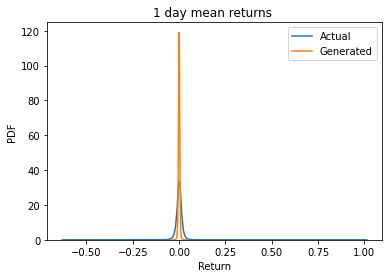

[1404, 1404]


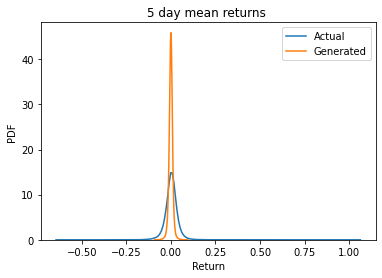

In [21]:
#Graph the results
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_base, 600, 1)
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_base, 600, 5)

Completed rep 1 of 10
Completed rep 2 of 10
Completed rep 3 of 10
Completed rep 4 of 10
Completed rep 5 of 10
Completed rep 6 of 10
Completed rep 7 of 10
Completed rep 8 of 10
Completed rep 9 of 10
Completed rep 10 of 10


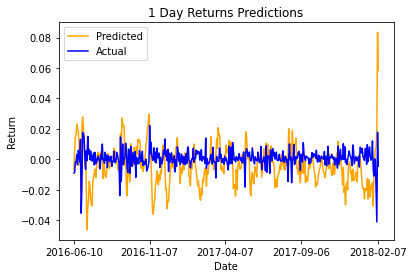

The average crash probability on crash days is 36.4%
The average crash probability on no crash days is 46.1%
The predicted and actual market movement agree on direction 48.92% of the time


In [22]:
with open('dates.txt', 'rb') as f:
        dates = pickle.load(f)
        
n_reps = 10
n_forward = 1
steps_back = 1
level = -0.005

samples_base = test_pred.sample_n_forward(DTSBN_base, 'data.pt', int(data.size()[1]*2/3), n_reps, n_forward, steps_back)
prices_base = test_pred.generate_prices(samples_base, 'unnormalized_data.pt', 'data_recovery.txt', n_forward)
predicted_base, actual_base = test_pred.check_val_weighted_return('unnormalized_data.pt', prices_base, n_forward, 'm_cap.pt', 'price_index_list.txt', 'size_index_list.txt')
test_pred.graph_change(predicted_base, actual_base, dates, n_forward)
c, nc = test_pred.show_prob(predicted_base, actual_base, level)
print('The average crash probability on crash days is {}%'.format(int(c*100)/100))
print('The average crash probability on no crash days is {}%'.format(int(nc*100)/100))
preds = torch.mean(predicted_base, 1)

agree = 0
for day in range(0, preds.size()[0]):
    if preds[day] * actual_base[day] > 0:
        agree += 1

print('The predicted and actual market movement agree on direction {}% of the time'.format(int((agree/preds.size()[0])*10000)/100))


#### 3.6 Model Optimization

In order to improve the performance of our model we implemented three hyperparmeter optimization techniques and evaluated our model performance under each type of optimization regime.  The three techniques we used were grid search, bayesian optimization, and hyperband search.  

##### 3.6.1 Grid Search

The first and most basic hyperparameter optimization technique we implemented was grid search.  This technique, while straightforward to implement, grows exponentialy fast as a function of the number hyperparameters optimized over.  For this reason we only optimized over two hyperparameters: *n_layers*, the number of layers in the DTSBN and a hyperparameter called *factor*, which controls the size of each layer in the belief network via the following equation
$$SizeOfLayer_i = SizeOfLayer_{i+1}/factor$$
In this search we tested 9 combinations of hyperparameters, with each  of them taking values from the set {1, 2, 3}.  Each model was trained for 40 minutes, giving the process a total budget of 360 minutes 

In [23]:
#Load Grid Search Optimized Model
with open('Grid_Configs.txt', 'rb') as f:
    grid_configs = pickle.load(f)
    
DTSBN_grid = DTSBN.DTSBN(grid_configs[0], grid_configs[1], grid_configs[2])
DTSBN_grid.load_weights('Grid_op_model_DTSBN.pt')
grid_configs[0].reverse()
DDBL_grid = DTSBN.DDBL(grid_configs[0])
DDBL_grid.load_state_dict(torch.load('Grid_op_model_DDBL.pt'))


<All keys matched successfully>

##### 3.6.2 Grid Search Empirical Results
We did not see a noticable improvement in the model performance after optimization.  However, we were concerned that this was due to the limited efficacy of grid search in computationally intensive optimization problems such as this one.

[52, 156, 468, 1404]


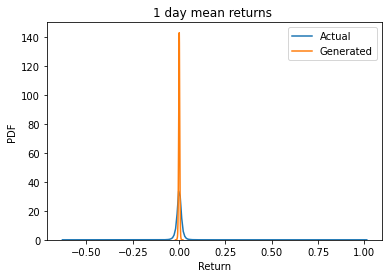

[52, 156, 468, 1404]


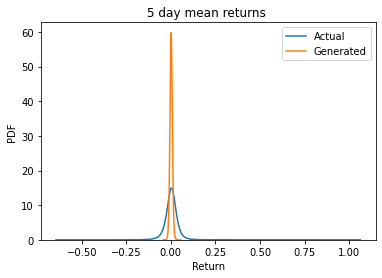

In [25]:
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_grid, 600, 1)
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_grid, 600, 5)

Completed rep 1 of 10
Completed rep 2 of 10
Completed rep 3 of 10
Completed rep 4 of 10
Completed rep 5 of 10
Completed rep 6 of 10
Completed rep 7 of 10
Completed rep 8 of 10
Completed rep 9 of 10
Completed rep 10 of 10


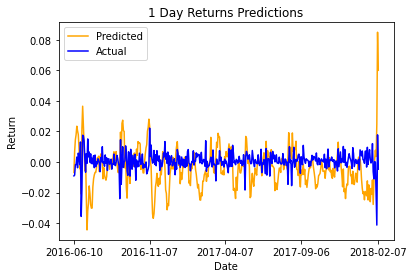

The average crash probability on crash days is 36.44%
The average crash probability on no crash days is 44.81%
The predicted and actual market movement agree on direction 50.11% of the time


In [26]:
samples_grid = test_pred.sample_n_forward(DTSBN_grid, 'data.pt', int(data.size()[1]*2/3), n_reps, n_forward, steps_back)
prices_grid = test_pred.generate_prices(samples_grid, 'unnormalized_data.pt', 'data_recovery.txt', n_forward)
predicted_grid, actual_grid = test_pred.check_val_weighted_return('unnormalized_data.pt', prices_grid, n_forward, 'm_cap.pt', 'price_index_list.txt', 'size_index_list.txt')
test_pred.graph_change(predicted_grid, actual_grid, dates, n_forward)
c, nc = test_pred.show_prob(predicted_grid, actual_grid, level)
print('The average crash probability on crash days is {}%'.format(int(c*100)/100))
print('The average crash probability on no crash days is {}%'.format(int(nc*100)/100))
preds = torch.mean(predicted_grid, 1)

agree = 0
for day in range(0, preds.size()[0]):
    if preds[day] * actual_base[day] > 0:
        agree += 1

print('The predicted and actual market movement agree on direction {}% of the time'.format(int((agree/preds.size()[0])*10000)/100))


##### 3.6.2 Hyperband Search and Bayesian Optimization

In order to explore the hyperparameter space of the model more effeciently, we implemented two mroe complex optimization techniques, Hyperband Search <sup>3</sup> and Bayesian Optimization<sup>5</sup>.  Hyperband uses a clever scheme to test a large amount of models quickly and only continue training on the ones that show promise.  This technique is fairly straight forward to implement and was done without using aditional packages.  Bayesian Optimization on the other hand involves variational inference and was therefore implemented in pyro.  We used the Upper Condifence Bound as our acqusition function and a gaussian process with a mater kernel as our surrogate function.

In [5]:
#Load Trained Models
with open('Bayes_Configs.txt', 'rb') as f:
    bayes_configs = pickle.load(f)
    
DTSBN_bayes = DTSBN.DTSBN(bayes_configs[0], bayes_configs[1], bayes_configs[2])
DTSBN_bayes.load_weights('Bayes_op_model_DTSBN.pt')
bayes_configs[0].reverse()
DDBL_bayes = DTSBN.DDBL(bayes_configs[0])
DDBL_bayes.load_state_dict(torch.load('Bayes_op_model_DDBL.pt'))

with open('Hyper_Configs.txt', 'rb') as f:
    hyper_configs = pickle.load(f)
    
DTSBN_hyper = DTSBN.DTSBN(hyper_configs[0], hyper_configs[1], hyper_configs[2])
DTSBN_hyper.load_weights('Hyper_op_model_DTSBN.pt')
hyper_configs[0].reverse()
DDBL_hyper = DTSBN.DDBL(hyper_configs[0])
DDBL_hyper.load_state_dict(torch.load('Hyper_op_model_DDBL.pt'))

NameError: name 'pickle' is not defined

##### 3.6.3 Hyperband Search and Bayesian Optimization Empirical Results

Unfortunately neither the Hyperband search nor the Bayesian optimization process yeilded significant improvements in model performance.  Under both regimes the best model found still generates return data that is more tightly centered around 0 than the actual return data.  Also, as with the case with the other models the sign on the predicted chaneg does not agree with reality more than half the time and the predicted crash probabilies on days when the market does not crash is higher than on days when it does.

[1, 2, 21, 173, 1404]


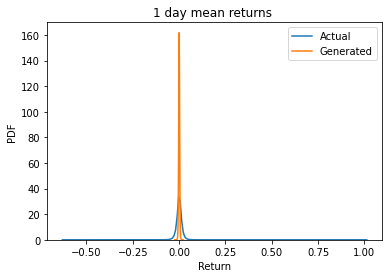

[1, 2, 21, 173, 1404]


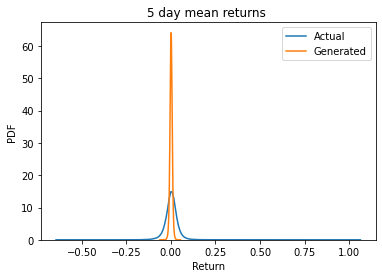

In [29]:
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_hyper, 1100, 1)
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_hyper, 1100, 5)

[2, 21, 172, 1404]


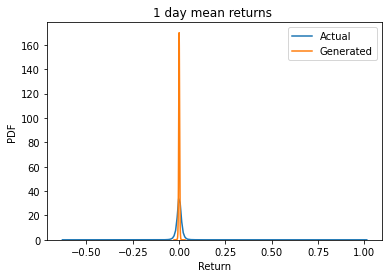

[2, 21, 172, 1404]


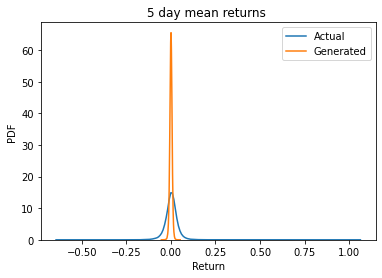

In [30]:
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_bayes, 1100, 1)
test_pred.graph_rets(train_data, 'data_recovery.txt', DTSBN_bayes, 1100, 5)

Completed rep 1 of 10
Completed rep 2 of 10
Completed rep 3 of 10
Completed rep 4 of 10
Completed rep 5 of 10
Completed rep 6 of 10
Completed rep 7 of 10
Completed rep 8 of 10
Completed rep 9 of 10
Completed rep 10 of 10


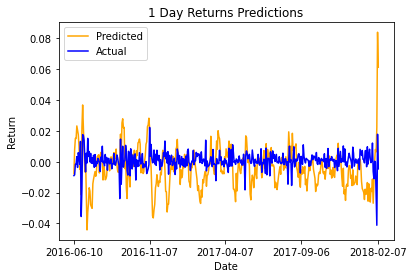

The average crash probability on crash days is 36.25%
The average crash probability on no crash days is 45.74%
The predicted and actual market movement agree on direction 48.44% of the time


In [31]:
samples_hyper = test_pred.sample_n_forward(DTSBN_hyper, 'data.pt', int(data.size()[1]*2/3), n_reps, n_forward, steps_back)
prices_hyper = test_pred.generate_prices(samples_hyper, 'unnormalized_data.pt', 'data_recovery.txt', n_forward)
predicted_hyper, actual_hyper = test_pred.check_val_weighted_return('unnormalized_data.pt', prices_hyper, n_forward, 'm_cap.pt', 'price_index_list.txt', 'size_index_list.txt')
test_pred.graph_change(predicted_hyper, actual_hyper, dates, n_forward)
c, nc = test_pred.show_prob(predicted_hyper, actual_hyper, level)
print('The average crash probability on crash days is {}%'.format(int(c*100)/100))
print('The average crash probability on no crash days is {}%'.format(int(nc*100)/100))
preds = torch.mean(predicted_hyper, 1)

agree = 0
for day in range(0, preds.size()[0]):
    if preds[day] * actual_base[day] > 0:
        agree += 1

print('The predicted and actual market movement agree on direction {}% of the time'.format(int((agree/preds.size()[0])*10000)/100))


Completed rep 1 of 10
Completed rep 2 of 10
Completed rep 3 of 10
Completed rep 4 of 10
Completed rep 5 of 10
Completed rep 6 of 10
Completed rep 7 of 10
Completed rep 8 of 10
Completed rep 9 of 10
Completed rep 10 of 10


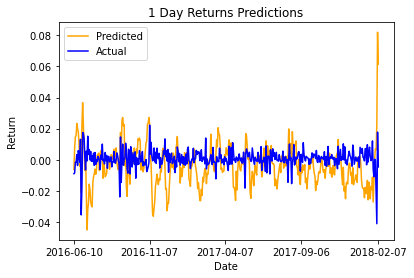

The average crash probability on crash days is 36.05%
The average crash probability on no crash days is 45.4%
The predicted and actual market movement agree on direction 48.68% of the time


In [32]:
samples_bayes = test_pred.sample_n_forward(DTSBN_bayes, 'data.pt', int(data.size()[1]*2/3), n_reps, n_forward, steps_back)
prices_bayes = test_pred.generate_prices(samples_bayes, 'unnormalized_data.pt', 'data_recovery.txt', n_forward)
predicted_bayes, actual_bayes = test_pred.check_val_weighted_return('unnormalized_data.pt', prices_bayes, n_forward, 'm_cap.pt', 'price_index_list.txt', 'size_index_list.txt')
test_pred.graph_change(predicted_bayes, actual_bayes, dates, n_forward)
c, nc = test_pred.show_prob(predicted_bayes, actual_bayes, level)
print('The average crash probability on crash days is {}%'.format(int(c*100)/100))
print('The average crash probability on no crash days is {}%'.format(int(nc*100)/100))
preds = torch.mean(predicted_bayes, 1)

agree = 0
for day in range(0, preds.size()[0]):
    if preds[day] * actual_base[day] > 0:
        agree += 1

print('The predicted and actual market movement agree on direction {}% of the time'.format(int((agree/preds.size()[0])*10000)/100))


## **4. Conclusion**

We researched and developed a pair of models that process and predict (to some degree) market movements. While neither model offered a substantial improvement over a random guess, we still believe that a Markovian model shows impressive potential for crash detection. Both models provided insights into the structure of their inference and the challenges faced in modeling extremely noisy data. While our attempt at a Deep Temporal Sigmoid Belief Network was only successful at predicting market movement a little less than half of the time, our first, fairly straightforward Hidden Markov model fared slightly better. This observation leads us to believe that improvements on the parallel-scale Kalman inference employed in the first model could lead to significant improvements in prediction accuracy and recall on that model. These improvements might stem from imbuing domain knowledge into the Kalman filter (perhaps in giving less weight to price decrements, as suggested by our graphical data) or better selection of factors and prior distributions for those factors. Noting that many crashes are precipitated by non-quantitative factors (e.g. news, speeches, conflicts), language data might prove a useful augment to market data, especially as far as detecting low probability, high-impact crash events for which numerical training data might be sparse. 


## **5. References**

<sup>1</sup> Gan, Zhe, et al. “Deep Temporal Sigmoid Belief Networks for Sequence Modeling.” ArXiv.org, ArXiv, 23 Sept. 2015, arxiv.org/abs/1509.07087.

<sup>2</sup>Hofmann, P., & Tashman, Z. (2020). Hidden Markov Models and their Application for Predicting Failure Events. arXiv preprint arXiv:2005.09971.

<sup>3</sup>Li, Lisha, et al. “Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization.” ArXiv.org, ArXiv, 18 June 2018, arxiv.org/abs/1603.06560.

<sup>4</sup>Minh, Andriy, and Karol Gregor. “Neural Variational Inference and Learning in Belief Networks.” Arxiv, Google DeepMind, 4 June 2014, arxiv.org/abs/1402.0030. 

<sup>5</sup>Snoek, Jasper, et al. “Practical Bayesian Optimization of Machine Learning Algorithms.” Arxiv, Harvard University, 13 June 2012, arxiv.org/abs/1206.2944. 
